# Game Studies Journal Scraper (source-code; beta)

By [Blinded Author] 

This is a Python program that scrapes all images from entries in the Game Studies Journal (gamestudies.org). 
Its purpose is to mine statistics about the use of other-than-text media in Game Studies entries (i.e. images, tables, links etc.) and by that in game studies discourse. 

**The present study and related paper were completed (conducted and also tested) prior to the publication of the latest issue of the journal (2021/04), which was published in December 2021. To keep this source code consistent with the submitted paper and its data, a clause was added in 'Part 2' (which will generate a notification printout) to limit the inquiry until issue 2021/3, for corroboration purposes. Nevertheless, the associated flag can be raised to True, in order to run the code for all issues (see comments).**

Main points: 
- [x] Scrape and save all images
- [x] Scrape entry titles
- [ ] Scrape Authors: Rather impossible to be done automatically for all entries; authors are entered inconsistently throughout the Journal. A function that partially works is provided, returning "JANE DOE" for unresolved authors. Nevertheless, for this context author names are not necessary. 
- [x] Scan for HTML tables  
- [x] Scan for iframes e.g. embedded Youtube videos (only one case).
- [x] Download animated GIFs (only one case).
- [x] Scan for HTML hyperlinks in entries and video links (YouTube, Vimeo, Twitch.tv, etc.).
- [x] Scan for linked files e.g. '.wav' files  (only one case)

## Notes
The Game Studies archive is rather inconsistent with its entries. 
- There is no automated way to figure out if an entry is an editorial, a book review, etc., besides reading it manually. Practically this can be done manually since the amount of entries is not unreasonable. However, that is beyond the scope of this present inquiry, which intends to follow an automated approach. 
- It's also practically impossible to retrieve the authors or keywords of publications consistently and throughout the journal. Author names, keywords and abstracts have not been entered with appropriate HTML tags. For inconclusive trials consult the bottom of this document.

For that the following scans and filters the links in the archive page of the journal (http://gamestudies.org/2103/archive - stored in the variable 'gameStudiesArchiveUrl' below) which lists all issues (from older to newer) and all entries (alphabetically by author).

### Structure, Conventions, Caveats
The general structure of the Journal is one Volume per year (since 2001), which includes multiple Issues. 
Each issue has an `issueID` which is the Volume number, or last 2 digits of the year, followed by 2 digits representing the Issue number. 
`IssueId` 0102, for example, is Volume 1 (and year 2001), Issue 2. 
The latest issue at the moment has `issueId` 2103, which is Volume 21, year 2021, issue 3. 

Entry URL Conventions: 
- **Issues before 2006**, follow a different URL convention, as in: 
    `<journal url> /<issueId>/<author_surname(s)>`
as in:  http://www.gamestudies.org/0102/newman/
- **Issues from 2006** onwards maintain the convention: 
   ` <journal url>/<issueId>/articles/<descriptor>`
   as in http://gamestudies.org/0601/articles/arnseth
   the 'descriptor' is often the surname(s) of the authors, but that convention is frequently broken.

As of 10/2021: 
- the number of unique issues is 41
- the number of unique entries is 279

The 279 entries found:
- EXCLUDE "Call for paper" entries (since they have a 'cfp' prefix to their URL and they can be filtered out)
- INCLUDE 
    - Editorials: that cannot be excluded automatically as they are not clearly marked (except from the first few editorial that go by a different url convention)
    - Book reviews: While some book reviews are marked in the title, or URL, most can only be identified from the Issue description, or by reading the content of the entry. Book reviews do not have Keywords, however, that appears to be the case for some paper entries as well. Thus, there is no algorithmic way of filtering them out.
    - Other known unmarked entry types such as interviews. 

# License and Use 

This is a blinded version of the source code, provided for review. 
The source code will be shared publicly after the blind review process, under GNU GPL v3 license. 

For novice programmers who want to run the code, pressing the play button will execute cell by cell. That is given that library dependencies are installed, as well as Python and Jupyter (https://jupyter.org/). 

Certain cells require downloading and processing data which might take a few minutes, depending on internet connection speeds. In these cases the progress is printed in text. Most blocks should run instanstaneously. In case of errors, it would be advised to restart the Kernel and run the program from the beginning. 

# Part 1: Setup
## Import Libraries for Web Scraping  & Set main variables

Note: Manually create subfolders for exporting data

In [1]:
#library imports 
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
from urllib.parse import urljoin, urlparse
import re
import os # for joining paths 

# will use the Game Studies Archive page, which lists all paper contributions 
gameStudiesArchiveUrl="http://gamestudies.org/2103/archive"

#boolean to save graphs
savePlots=True
#boolean to save dataframes
saveDataframes=False 

#Folders to export - they should already exist 
#image export folder 
imageExportFolder="img_export"
#data export folder 
dataExportFolder='data_export'


## Functions for Scraping 
First cell contains a cumulative function that returns most useful information.   
The second cell contains distinct functions.

In [2]:
# Cumulative entry to get Entry title, tables, images 
def getEntryInfo(url, verbose=False): 
    #parse document 
    html = urlopen(url)
    bs = BeautifulSoup(html, 'html.parser', from_encoding="UTF-8") ## need to force UTF 8 encoding, else it gets it wrong
    #for images ------------------------
    images= bs.find_all('img')
    imageUrls=[]
    for image in images:
        
        imageUrl=image.get('data-src')#this to download animated gifs 
        if imageUrl==None: # if no 'data-src', then just 'src'
            imageUrl=image['src']
        #ignore header images, these start with '/gfx/' (appers to be the folder for internal images)
        if '/gfx/' in imageUrl: 
            continue #skip item 
        #one particular entry (../0401/woods/) has an invalid footer image (without extension) that we can filter out
        #that is ->  http://www.w3.org/Icons/valid-html401
        elif len(imageUrl.split(".")[-1])>4: 
            continue
        #otherwise image is valid 
        imageUrls.append(imageUrl)
    
    #for titles ------------------------
    headerContent= bs.find_all('h1') 
    potentialTitle=''
    if len(headerContent)>0: 
        potentialTitle=headerContent[0].text.strip()
        if potentialTitle=='Game Studies': # then title is under H2
            h2= bs.find_all('h2')# returns more than 1
            if len(h2)>0: 
                potentialTitle= h2[0].text.strip()
            else: potentialTitle= h2.text.strip()
                
        #clean up 
        potentialTitle= potentialTitle.replace("   ", "") #some entries have multiple spaces, this kills some of them
        potentialTitle=potentialTitle.replace("\n", "-") #removes new lines 
   
    #for tables--------------------------
    tables= bs.find_all('table')
    validTableCount=0
    if len(tables)>0: 
#         print(str(len(tables))+" tables in "+ url)
        for table in tables: 
            tableText= table.text.strip()
            # if it starts with 'Figure', Skip and break iteration 
            if tableText.startswith("Figure"): 
                if verbose: print("Starts with Figure (Skip) " + url) 
                continue
            # if length is too high, it's lame HTML fomatting, Skip 
            tableLength= len(tableText)
            if tableLength > 5000: 
                if verbose: print ("Content too long, lame html formatting (skip) "+ url)
            else: 
                validTableCount+=1
    #return order: [title, image urls, table count] 
    return [potentialTitle,imageUrls, validTableCount]

# result=getEntryInfo("http://gamestudies.org/0801/articles/hutch")
# print(result)

In [3]:
def is_valid(url): # from https://www.thepythoncode.com/article/download-web-page-images-python
    """
    Checks whether `url` is a valid URL.
    """
    parsed = urlparse(url)
    return bool(parsed.netloc) and bool(parsed.scheme)

#function to scrape all URLS from a page 
def getLinksInPage(url): 
    req= Request(url)#open webpage
    page= urlopen(req)
    bs = BeautifulSoup(page)

    # get all hyperlinks from archive, and make list 
    links=[]
    for link in bs.findAll('a'): 
        links.append(link.get('href'))
    return links

# function to get image urls from a webpage  
def getImages(url):
    html = urlopen(url)
    bs = BeautifulSoup(html, 'html.parser')
    images= bs.find_all('img')
    imageUrls=[]
    for image in images:
        imageUrl=image['src']
        #ignore header images, these start with '/gfx/' (appers to be the folder for internal images)
        if '/gfx/' in imageUrl: 
            continue #skip item 
        #otherwise image is valid 
        imageUrls.append(imageUrl)
        
    return imageUrls

def getTitle(url): # .... some titles are formatted as h1,most as h2.. mammma mia
    html = urlopen(url)
    bs = BeautifulSoup(html, 'html.parser', from_encoding="UTF-8") ## need to force UTF 8 encoding, else it gets it wrong
    #check for H1 (header content )
    headerContent= bs.find_all('h1')# returns more than 1... 
    if len(headerContent)>0: 
        potentialTitle=headerContent[0].text.strip()
        if potentialTitle!='Game Studies': 
            return potentialTitle
        else: 
            h2= bs.find_all('h2')# returns more than 1
            if len(h2)>0: 
                return h2[0].text.strip()
    
#for test 
#getImages("http://gamestudies.org/0801/articles/hutch")# works 
# getTitle("http://gamestudies.org/0801/articles/hutch")#works for all
# getAuthor("http://gamestudies.org/0801/articles/hutch") # does not work for all


#Function to get HTML tables. Up to entry #60, results are correct
#Manually filtering out problematic HTML formatting and Figures entered in table format 
# use 'verbose=True' flag to get feedback on what is filtered out 
def getTables(url, verbose=False):
    html = urlopen(url)
    bs = BeautifulSoup(html, 'html.parser')
    tables= bs.find_all('table')
    if len(tables)==0: 
        return 0
    else: 
        validTableCount=0
#         print(str(len(tables))+" tables in "+ url)
        for table in tables: 
            tableText= table.text.strip()
            # if it starts with 'Figure', Skip and break iteration 
            if tableText.startswith("Figure"): 
                if verbose: print("Starts with Figure (Skip) " + url) 
                continue
            # if length is too high, it's lame HTML fomatting, Skip 
            tableLength= len(tableText)
            if tableLength > 5000: 
                if verbose: print ("Content too long, lame html formatting (skip) "+ url)
            else: 
                validTableCount+=1
        return validTableCount

# function to search for embedded content
# there is only one case of an embedded video in 41 issues; so this is not very useful at large  
def getIframeLinks(url): 
    req= Request(url)
    page= urlopen(req)
    bs = BeautifulSoup(page)
    iframes= bs.findAll('iframe')
    if len(iframes)>0: 
        print(url)
        for iframe in iframes: 
            print(iframe['src'])

# Part 2: Scan and Filter Archive Entries & Scrape Information 
## Get all HTML links from Game Studies Archive 

In [4]:
print("Scanning for links in: "+gameStudiesArchiveUrl)
#get all links in Game Studies archive page 
links=getLinksInPage(gameStudiesArchiveUrl)

print ("Found "+ str(len(links))+ " links in: "+ gameStudiesArchiveUrl)    

Scanning for links in: http://gamestudies.org/2103/archive
Found 357 links in: http://gamestudies.org/2103/archive


## Filter links to get valid entries 
Entries can include book reviews and editorials as these cannot be filtered out automatically (see notes in code)

In [6]:
# GameStudies Joural publication structure
# one volume per year with multiple issues, volume 1-> 2001; volume 2 -> 2002 etc. 
# Issues up until Volume 5(2005) are filed as ../<issue number>/<author(s)>/ (not slash in the end)
# Later, from Volume 6 (2006) issues are published as ../<issue number>/articles/<author(s)>
# where <issue number> is last 2 digits of year, and then number of issue 
# example  '0802' is issue 2 of 2008. Issues start counting from 0 every year. 

#symmetrical arrays 
urls=[] #list of urls for journal entries
issueIds=[] # list of 4-digit issue numbers
issueYears=[] # year of publication 
issueNumbers=[] #number of issue in year/volume 
ascendingPublicationIndexes=[]
ignoreUrls=[]

verbose=False 

# skip the latest issue (2021 / 4 - id: 2104) that was published after this study
# change the flag below to True to scan all published issues 
scanAllIssues= False
maxIssueId=2103
if scanAllIssues== False: 
    print("***The scan will filter out entries in issues later than "+ str(maxIssueId)+"***")

# There appears to be no easy 'big-data' way to filter out entries that are not papers, 
# such as editorials, book reviews, interviews etc. 
# Most such content is only marked so in the issue table of contents,
# or in the text itself, not in the entry's title, or url; neither via keywords.
# One way would be to check if an entry has keywords or not, (reviews tend not to have keywords)
# however, in certain cases there are papers without keywords (see Montfort, issue 0601)
# One type that can be found easily are 'call for papers' as they include the prefix 'cfp'
# -The 'entriesToIgnore' array contains all patterns found in distinguishing non-paper entries,
# however it does not catch all editorials or book reviews. 
# - Therefore, I decide to only filter out and ignore 'call for papers' which is more consistent. 

cfp_prefix='cfp' #this will catch all 'calls for papers' published (n=2), and is by default enabled 

# Below part of unused code if this is true it will filter out entries containing the following series of characters; 
#this does not catch all editorials nor book reviews, therefore inconclusive
ignoreHeavy=False  
entriesToIgnore=['cfp', 'aarseth', 'review','reivew_vella', 'editorial']

for link in links:
    parse= link.split("/")#split url to get paper issue unumbers and other url info. 

    if (len(parse)>5 ):
        try: 
            # get entry name, useful to filter out known keywords for non-papers such as call for papers ('cpf' prefix)
            entryName= parse[-1]
            if (entryName==""): 
                entryName=parse[-2]
            
            #exclude call-for-papers entries 
            if entryName.startswith(cfp_prefix) : 
                ignoreUrls.append(link)
                if (verbose): print("Ignoring CFP entry:  "+ entryName+" - "+ link)
                continue
                
            #by default off; as it is not effective to catch all non-paper content
#             if ignoreHeavy: 
#                 if any(sub in entryName for sub in entriesToIgnore) : 
#                     ignoreUrls.append(url)
#                     print("Ignoring entry:  "+ entryName+" - "+ link)
#                     continue
           
            # get issue info 
            issueId= int( parse[3]) # prone to error, that's why the 'try:'
#             print(str(issueId)+"---" + link)
            issueYear= int(issueId/100)+2000 # get issue year 
            issueNumber= issueId%100 # get issue number, last 2 digits 
            
            if issueId > maxIssueId: 
                print ("Skiping entry with issue id: "+ str(issueId))
                continue
            
            if (issueYear<2005 or (issueYear>2005 and parse[4]=='articles')):
                if not link in urls:  # if url is unique  
                    urls.append(link)
                    issueIds.append(issueId)
                    issueYears.append(issueYear)
                    issueNumbers.append(issueNumber)
                else: 
                    ignoreUrls.append(link)
                    if verbose: print("Skipping duplicate url: "+ link )
                    continue
            
            else: #url does not correspond to journal entry 
                ignoreUrls.append(link)
                if verbose: print ('skip: '+ link )
                
        except ValueError:
            print("parse error, skip")
    else : #url does not correspond to journal entry 
        ignoreUrls.append(link)
        if verbose: print("Ignoring: "+ link)

# get all unique issues, sort them, and make a dictionary of [issueId]: index 
# add that to symmetrical array 
uniqueIssueIds=[]
for id in issueIds:
    if not( id in uniqueIssueIds): 
        uniqueIssueIds.append(id)
        
uniqueIssueIds.sort()
# print(uniqueIssueIds)
dictionaryOfIssues={} # dictionary of issueIds, with index of publication starting from 1
#key is issueId, value is index 
counter=1
for id in uniqueIssueIds:
    dictionaryOfIssues[id]=counter
    counter+=1

#make list 
for paperIssueId in issueIds: 
    ascendingPublicationIndexes.append(dictionaryOfIssues[paperIssueId])


#get metrics and printout 
nEntries=len(urls)
nIssues =len(uniqueIssueIds) #number of issues

print("Number Entries in Game Studies Journal: "+ str(nEntries))
print("Ignored urls: "+ str(len(ignoreUrls)))
print("Number of Journal Issues: "+ str(nIssues))

***The scan will filter out entries in issues later than 2103***
Skiping entry with issue id: 2104
Skiping entry with issue id: 2104
Skiping entry with issue id: 2104
Skiping entry with issue id: 2104
Skiping entry with issue id: 2104
Skiping entry with issue id: 2104
Skiping entry with issue id: 2104
Skiping entry with issue id: 2104
Skiping entry with issue id: 2104
Number Entries in Game Studies Journal: 279
Ignored urls: 69
Number of Journal Issues: 41


## Scrape all entries for title information, and amounts of images and HTML tables 

In [7]:
#Scrape all information 
entryImageUrls=[] #img urls (list of lists) 
entryImageCount=[] #img count
entryTitles=[] #entry title 
entryTables =[]

print ("Scanning entries for Images, Titles and Tables. Wait for confirmation message (~1-3min)")
counter=0 
for url in urls: 
    info=getEntryInfo(url)# [title, imageUrls, numberOfTables]
    entryTitles.append(info[0])
    entryImageUrls.append(info[1])
    entryImageCount.append(len(info[1]))
    entryTables.append(info[2])
    #interate counter and print every 20 
    counter+=1
    if counter % 20==0 : 
        print ("..Entries Processed: "+ str(counter)+" of "+str(nEntries)+"..")

# Metrics 
nImages=sum(entryImageCount)
nTables= sum(entryTables)
print("Scan Finished. " + str(nImages)+ " Images & "+ str(nTables)+" HTML Tables found in "+str(nEntries)+" entries of " +str(nIssues)+" issues.")

Scanning entries for Images, Titles and Tables. Wait for confirmation message (~1-3min)
..Entries Processed: 20 of 279..
..Entries Processed: 40 of 279..
..Entries Processed: 60 of 279..
..Entries Processed: 80 of 279..
..Entries Processed: 100 of 279..
..Entries Processed: 120 of 279..
..Entries Processed: 140 of 279..
..Entries Processed: 160 of 279..
..Entries Processed: 180 of 279..
..Entries Processed: 200 of 279..
..Entries Processed: 220 of 279..
..Entries Processed: 240 of 279..
..Entries Processed: 260 of 279..
Scan Finished. 659 Images & 70 HTML Tables found in 279 entries of 41 issues.


### Get sums of image file formats
Informative but not necessary

In [8]:
#analyze image types // might be useful  
imageTypeDict={}
for paperImages in entryImageUrls: 
    if len(paperImages)>0: 
        for image in paperImages: 
            extension = (image.split("."))[-1].lower() #find part after period (file extension) and make lowercase
            if len(extension)>4: 
                print ("Ignoring image: "+ image)
                continue # only one occurence of -> http://www.w3.org/Icons/valid-html401 in (0401/woods/)
            if not extension in imageTypeDict.keys(): 
                imageTypeDict[extension]=0
            imageTypeDict[extension]+=1

#consolidate JPG and JPEG to one 
imageTypeDict['jpg']+= imageTypeDict['jpeg'] 
del imageTypeDict['jpeg']

#print 
print("Image file formats for " + str(sum(entryImageCount))+" images:")
for k in imageTypeDict: 
    perc= imageTypeDict[k]/nImages*100 
    print (str(k)+": "+ str(imageTypeDict[k])+" -> " +str(perc)+"%")
    
print("Note: only PNG is a 'lossless' format; journal guidelines ask for JPG, or GIF.")


Image file formats for 659 images:
jpg: 509 -> 77.2382397572079%
png: 70 -> 10.62215477996965%
gif: 80 -> 12.139605462822459%
Note: only PNG is a 'lossless' format; journal guidelines ask for JPG, or GIF.


# Part 3: Create GSJ Entries dataframe (spreadsheet) 
## Load Libraries for Statistics and Graph Plots

In [9]:
#Import math & plot libs 
import pandas as pd #dataframes & plotting
import matplotlib.pyplot as plt # matplotlib for additional plotting
import matplotlib.ticker as mtick
import numpy as np #math

## Create dataframe of Entries

In [10]:
#dataframe per entry 
entry_data={
    'title': entryTitles,
    'url' : urls,
    'imageUrls': entryImageUrls,
    'imageCount': entryImageCount, 
    'tableCount': entryTables,
    'issueId': issueIds, 
    'year': issueYears, 
    'issueNumber': ascendingPublicationIndexes
}

#create DF
edf= pd.DataFrame(entry_data)#create data frame
edf.sort_values(by=['issueNumber'], inplace=True)# sort by issue number 
edf['entryIndex']= range(0, len(urls))
edf.set_index('entryIndex', inplace=True)

#export dataframe as CSV (subfolder must exist)
if saveDataframes==True: 
    filename= 'gsc_df_entries_1.csv'
    edf.to_csv(os.path.join(dataExportFolder,filename))
    print("Saved Dataframe as: " + filename)
    
#show beginning of DF
edf.head()

,title,url,imageUrls,imageCount,tableCount,issueId,year,issueNumber
entryIndex,,,,,,,,
0,The Gaming Situation,http://www.gamestudies.org/0101/eskelinen/,"[eskelinen1.gif, eskelinen2.gif, eskelinen3.gi...",4,0,101,2001,1
1,Is It Possible to Build Dramatically - Compel...,http://www.gamestudies.org/0101/bringsjord/,"[2_files/img3.gif, 3_files/img4.gif, 6_files/i...",27,1,101,2001,1
2,The repeatedly lost art of - studying games,http://www.gamestudies.org/0101/juul-review/,[],0,0,101,2001,1
3,The Sims: Grandmothers are cooler than trolls,http://www.gamestudies.org/0101/frasca/,[],0,0,101,2001,1
4,Beyond Myth and Metaphor*,http://www.gamestudies.org/0101/ryan/,[],0,0,101,2001,1


## 3.1 Plot Image Frequency in Single Papers

Saved graph as: gsc_image_frequency.png


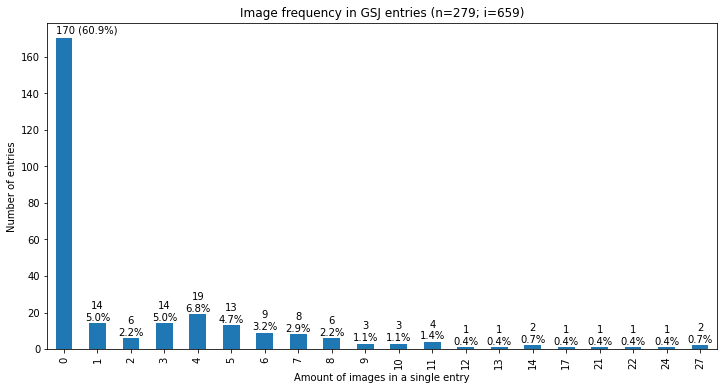

In [11]:
#Sort papers by image count and draw graph 
byImgCount=edf.sort_values(by=['imageCount'])

# print("Mean image count per entry: "+ str(byImgCount.mean()))

byImgCount= byImgCount['imageCount'].value_counts(sort=False)#, normalize=True)
graph=byImgCount.plot(kind='bar', title="Image frequency in GSJ entries (n="+ str(nEntries)+"; i="+str(nImages)+")",
                xlabel="Amount of images in a single entry", ylabel='Number of entries', 
               figsize=(12,6))

#annotate bars with values 
#add percentage only to first bar (no space in the rest)
for i in range(0, len(graph.patches)): 
    p= graph.patches[i]
    count= p.get_height()
    perc= np.round((p.get_height()/nEntries)*100., decimals=1)
    
    label= count
    if i==0: ##add percentage 
        label = str(count)+' ('+ str(perc)+ '%)'
        graph.annotate(label,
                   (p.get_x()+p.get_width()*0.0, p.get_height()),ha='left',
                   va='center',xytext=(0, 8),textcoords='offset points') 
    else: # just number
        label = str(count)+"\n"+str(perc)+"%"
        graph.annotate(label,
                   (p.get_x()+p.get_width()*0.5, p.get_height()+2),ha='center',
                   va='center',xytext=(0, 8),textcoords='offset points') 

#save plot 
if savePlots==True: 
    filename= 'gsc_image_frequency.png'
    graph.get_figure().savefig(os.path.join(dataExportFolder,filename), bbox_inches = 'tight', dpi=300)
    print("Saved graph as: " + filename)

image-bearing entries:109
Standard deviation:5.5861147824380675
Saved graph as: gsc_image_count_probability.png


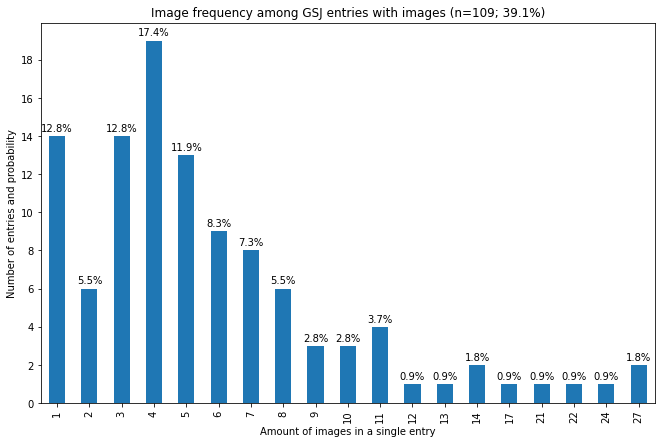

In [12]:
#image likelihood 
#exclude zero 

byImgCount_exclZero= byImgCount.drop(0)
# print(byImgCount_exclZero)
nImageBaringEntries= byImgCount_exclZero.sum()
#percentage over all entries 
ibe_perc=np.round(nImageBaringEntries/nEntries*100., decimals=1)
print("image-bearing entries:"+ str(nImageBaringEntries))

print("Standard deviation:"+ str(byImgCount_exclZero.std()))

graph= byImgCount_exclZero.plot(kind='bar', 
                                title="Image frequency among GSJ entries with images (n="+ str(nImageBaringEntries)+"; "+ str(ibe_perc)+"%"+")",
                                xlabel="Amount of images in a single entry", 
                                ylabel='Number of entries and probability', 
                                figsize=(11,7), 
                                yticks= range(0,20)[::2])

# graph.xticks([0::20])

#annotate bars with values 
#True for adding Percentage, False for just count
for p in graph.patches: 
    count= p.get_height()
    perc= np.round((p.get_height()/nImageBaringEntries)*100., decimals=1)
    graph.annotate('\n'+ str(perc)+ '%',
               (p.get_x()+p.get_width()/2., p.get_height()+0.3),ha='center',
               va='center',xytext=(0, 8),textcoords='offset points')
    

#save plot 
if savePlots==True: 
    filename= 'gsc_image_count_probability.png'
    graph.get_figure().savefig(os.path.join(dataExportFolder,filename), bbox_inches = 'tight', dpi=300)
    print("Saved graph as: " + filename)

## 3.2 Plot HTML Table Frequency in Single Papers

Tables in 36 entries.
Saved graph as: gsc_table_frequency.png


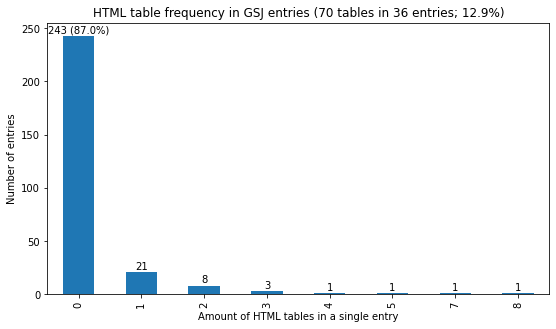

In [13]:
# Plot frequency of Tables in papers 
byTableCount=edf.sort_values(by=['tableCount'])

#sort by table count 
byTableCount= byTableCount['tableCount'].value_counts(sort=False)#, normalize=True)


#exclude zero and get sum 
byTableCount_exclZero= byTableCount.drop(0)
nTableBaringEntries=byTableCount_exclZero.sum()
tableEntryPerc= np.round(nTableBaringEntries/nEntries*100., decimals=1)
print("Tables in "+ str(nTableBaringEntries)+" entries.")

#plot 
gtitle="HTML table frequency in GSJ entries ("+str(nTables)+" tables in "+str(nTableBaringEntries)+" entries; "+str(tableEntryPerc)+"%)"
graph=tableCountPlot= byTableCount.plot(kind='bar', 
                                        title=gtitle, 
                                        xlabel="Amount of HTML tables in a single entry", ylabel='Number of entries', 
                                        figsize=(9,5))

#annotate bars with values, add percentage to first bar 
for i in range(0, len(graph.patches)): 
    p =graph.patches[i]
    label= p.get_height()
    if i==0: #get percentage for first one 
        perc= np.round(label/nEntries*100.)
        label =str(label) +" ("+str(perc)+"%)"
    graph.annotate(label,
                   (p.get_x()+p.get_width()/2., p.get_height()),ha='center',
                   va='center',xytext=(0, 6),textcoords='offset points') 
    
#save plot 
if savePlots==True: 
    filename='gsc_table_frequency.png'
    graph.get_figure().savefig(os.path.join(dataExportFolder,filename), bbox_inches = 'tight', dpi=300)
    print("Saved graph as: " + filename)

## Part 4: Create Journal Issues dataframe

In [14]:
import math # for floor function
# Get per issue metrics 
# get mean number of images per issue 
meanImgCount_perIssue=edf.groupby('issueId')['imageCount'].mean()
# get mean by year 
meanImageCount_perYear= edf.groupby('year')['imageCount'].mean()# print(meanImageCount_perYear)
# get image sum per issue 
imageSumPerIssue= edf.groupby('issueId')['imageCount'].sum()
#images per Issue by entry 
imagesPerIssueByEntry= edf.groupby('issueId')['imageCount'].apply(list)
# entries per issue 
# sortByIssue= edf.groupby('issueId')
# entriesPerIssue= sortByIssue['issueId'].value_counts()# edf['issueId'].value_counts()
entriesPerIssue= edf['issueId'].value_counts().sort_index()
# print(entriesPerIssue)

# assemble data  
issue_data={
    'issueKey': dictionaryOfIssues.keys(),
    'issueNumber': dictionaryOfIssues.values(),
    'imageSumPerIssue': imageSumPerIssue, 
    'imagesPerEntry': imagesPerIssueByEntry, 
    'issueImgMean': meanImgCount_perIssue,
    'entrySumPerIssue': entriesPerIssue
}

#assemble data
idf= pd.DataFrame(issue_data)
#create column with entry with max images per issue 
idf['mostImagesIn1Entry']= [max (x) for x in idf['imagesPerEntry']]
# get median 
idf['median']=[np.median(x) for x in idf['imagesPerEntry'].values.tolist() ]#.mean(1) #[x.median() for x in  idf['imagesPerEntry']]

# get friendly labels for plotting 
issueLabels=[]
for index, row in idf.iterrows():
    k= row['issueKey']
    vol=  row['issueKey']%10
    year= 2000+ math.floor(k/100)
    label= str(row['issueNumber'])+"-"+str(year)+"/"+ str(vol)
    issueLabels.append(label)
#     print (str(k)+"-"+ label)

#add column
idf['issueLabel']= issueLabels

#####
#find contribution of top-most contributor
topContributorIssuePerc={}
for i, row in idf.iterrows(): 
    imaxc= row['mostImagesIn1Entry']
    itotc=row['imageSumPerIssue']
    if itotc==0: 
        topContributorIssuePerc[i]=(0)
    else: 
        topContributorIssuePerc[i]=np.round(imaxc/itotc, decimals=2)

#topmost contributors, that account for more than half of issue images
topContribOverHalf=0
toContribAll=0
zeroImageIssues=0

for k in topContributorIssuePerc: 
    val= topContributorIssuePerc[k]
    if val==1:   #for entries that amount to all issue images
        if verbose: 
            print(str(k)+ " - "+ str(val)+" --> top img contrib. accounts for 100%")
        toContribAll+=1
        topContribOverHalf+=1
    elif val>=.5: 
        if verbose: 
            print(str(k)+ " - "+ str(val)+" --> top img contrib. accounts for OVER 50%")
        topContribOverHalf+=1
    elif val==0: 
        if verbose: 
            print(str(k)+ " --> ZERO images in issue")
        zeroImageIssues+=1
    else: 
        if verbose:
            print (str(k)+ " - "+ str(val))
  

print("Cases where one entry accounts for more than half of issue images: "+ str(topContribOverHalf))
print("Cases where one entry accounts for all issue images: "+ str(toContribAll)) 
print("Cases where image count is zero: "+ str(zeroImageIssues)) 

#export dataframe as CSV (subfolder must exist)
if saveDataframes==True: 
    filename= 'gsc_df_issues.csv'
    edf.to_csv(os.path.join(dataExportFolder,filename))
    print("Saved Dataframe as: " + filename)


#print 
idf.head()

Cases where one entry accounts for more than half of issue images: 26
Cases where one entry accounts for all issue images: 5
Cases where image count is zero: 3


,issueKey,issueNumber,imageSumPerIssue,imagesPerEntry,issueImgMean,entrySumPerIssue,mostImagesIn1Entry,median,issueLabel
101,101,1,31,"[4, 27, 0, 0, 0]",6.200000,5,27,0.0,1-2001/1
102,102,2,8,"[0, 0, 1, 0, 7]",1.600000,5,7,0.0,2-2001/2
202,202,3,7,"[3, 0, 4, 0, 0]",1.400000,5,4,0.0,3-2002/2
301,301,4,12,"[10, 1, 0, 0, 0, 1, 0]",1.714286,7,10,0.0,4-2003/1
302,302,5,17,"[0, 0, 2, 1, 14]",3.400000,5,14,1.0,5-2003/2


## 4.1 Plot Image Count per Issue

Saved graph as: gsc_images_per_issue.png


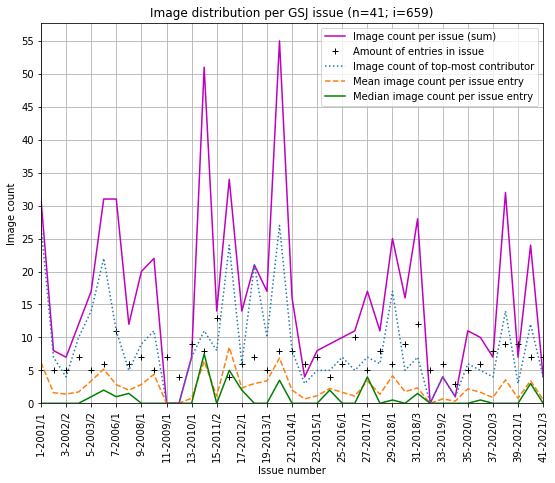

In [15]:
## PLOT 
#set size
plt.figure(figsize=(9,7))
#Plots 
plt.plot(idf['issueLabel'],idf['imageSumPerIssue'],'m', label="Image count per issue (sum)")
#plot entry count 
plt.plot(idf['issueLabel'],idf['entrySumPerIssue'],'+',color='k', label='Amount of entries in issue' )
#top image contributor
plt.plot(idf['issueLabel'],idf['mostImagesIn1Entry'],':', label="Image count of top-most contributor")
# issue image mean 
plt.plot(idf['issueLabel'],idf['issueImgMean'],'--', label="Mean image count per issue entry")
# issue image count median
plt.plot(idf['issueLabel'],idf['median'],'g', label="Median image count per issue entry")


#To plot imagecount minus topmost contributor  
# imageCountNormalized=[]
# for i in range(0, len( idf['imageSumPerIssue'])): 
#     x= idf['imageSumPerIssue'].iloc[i]- idf['max'].iloc[i]
#     imageCountNormalized.append(x)
# idf['imageSumNormalized']= imageCountNormalized
# plt.plot(idf['issueLabel'],idf['imageSumNormalized'], 'r', label="Issue image count excluding top contrib.")

# Axes Ticks 
# plt.xticks(issueLabels[::2]) #idf['issueNumber'][::2])
plt.xticks(idf['issueLabel'][::2] , rotation=90)
plt.yticks(range(0,58)[::5])
plt.xlim(xmin=0, xmax=40) #edit x bounds to elminate gaps left and right 
plt.ylim(ymin=0)
plt.grid(True) # enable background grid 

# Labels  
plt.legend()
plt.title("Image distribution per GSJ issue (n="+str(nIssues)+"; i="+str(nImages)+ ")")
plt.xlabel('Issue number')
plt.ylabel('Image count')

# save plot (needs to be called before plt.shot() in the case of matplotlib)
if savePlots==True: 
    filename='gsc_images_per_issue.png'
    plt.savefig(os.path.join(dataExportFolder,filename),bbox_inches='tight', dpi=300)
    print("Saved graph as: " + filename)

# show figure 
plt.show()

## Part 5: Create Images dataframe, export CSV and manually annotate image types 

### 5.1 Create Images Dataframe
(a function to download all images locally is provided below in the *Annex* section)

1. Create Dataframe containing all images (1 row per image)
2. Export as CSV spreadsheed 
    - that can be opened with various Spreadsheet editors (for example also Excell: Data/From Text/CSV) to manually edit.
    - after annotation in the 'image_annotation' column, 'Save As' CSV, and take note of the separator between values (in CSV usually is ',')

In [16]:
# Create a table for manual annotation of images 
l_index=[]
l_paperIndex=[]
l_paperUrl=[] 
l_imageUrl=[]
l_paperTitle=[] #not needed just to make the table easier to read, and to cross check 

for index, row in edf.iterrows(): 
    for imgUrl in row['imageUrls']: 
        l_paperIndex.append(index)# index of paper
        l_imageUrl.append(imgUrl)#name/url of image
        l_paperUrl.append (row['url'])# url of paper
        l_paperTitle.append(row['title'])
            
#create dataframe 
imageDF= pd.DataFrame({
    "paper_index": l_paperIndex, 
    "paper_title": l_paperTitle, 
    "paper_url": l_paperUrl, 
    "image_url": l_imageUrl, 
    "image_annotation": [""]*len(l_paperIndex)# Add column to manually annotate 
})


#for preview 
imageDF.head()

,paper_index,paper_title,paper_url,image_url,image_annotation
0,0,The Gaming Situation,http://www.gamestudies.org/0101/eskelinen/,eskelinen1.gif,
1,0,The Gaming Situation,http://www.gamestudies.org/0101/eskelinen/,eskelinen2.gif,
2,0,The Gaming Situation,http://www.gamestudies.org/0101/eskelinen/,eskelinen3.gif,
3,0,The Gaming Situation,http://www.gamestudies.org/0101/eskelinen/,eskelinen4.gif,
4,1,Is It Possible to Build Dramatically - Compel...,http://www.gamestudies.org/0101/bringsjord/,2_files/img3.gif,


### 4.2 Export CSV for manual annotation (off)

In [17]:
#(change value to True for saving, or skip)
# Export to CSV 
exportImagesCSV= False
i_filename='gsc_df_for_image_annotation.csv'
#export CSV of all images 
if exportImagesCSV: 
    imageDF.to_csv(os.path.join(dataExportFolder,i_filename))
    print('Saved Images Dataframe as: ' + i_filename)

### 4.3 Load table after manual annotation and organize labels
(CSV included. For making another one make note of value separator, usually it is ','. In this case I edited and exported using Excell which used ';' as separator)

In [97]:
# Reload previous csv and make dataframe 
#File used for investigation supplied as "GSJ image list with manual classification annotations.csv"
#Rename, load and reference name below to use
csvFileToLoad= "data_input/image_classification_file.csv"
annotatedImages_df= pd.read_csv(csvFileToLoad, sep=';')# export to CSV from Excell uses <semicolon> separator 

#get all unique labels 
imageTypes=[]
for index, row in annotatedImages_df.iterrows(): 
    imageType= row['image_annotation'].lower().strip().title()# get annotation in lower case
    #add to list of unique values 
    if not imageType in imageTypes: 
        imageTypes.append(imageType)
    #rewrite image type as uniform
    annotatedImages_df.loc[index, 'image_annotation']= imageType

print("Unique image classes:")
print(imageTypes)
# annotatedImages_df.head()


Unique image classes:
['Diagram', 'Table', 'Film Screenshot', 'Algorithm', 'Game Screenshot', 'Text', 'Glyph', 'Picture', 'Graph', 'Music Score', 'Screenshot', 'Photo', 'Illustration', 'Animated Gif', 'Translation Text', 'Text - Illustration']


### 4.4 Plot Classification of image types

Saved graph as: gsc_image_types.png


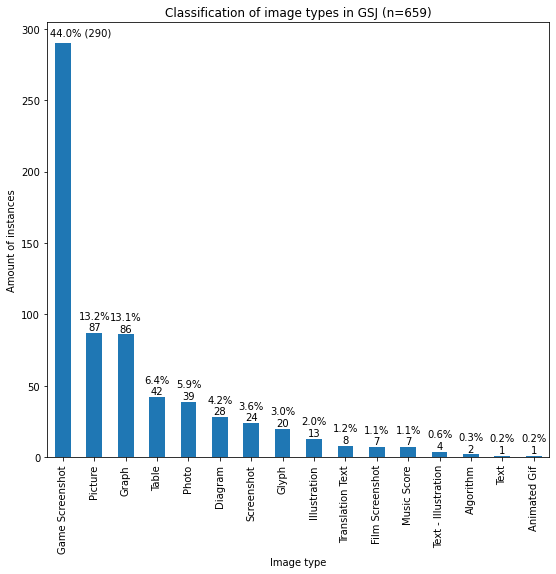

In [98]:
#sort by values
sortedByAnnotation= annotatedImages_df.sort_values(by=['image_annotation'])
# Count the occurrence of unqiue elements and store in a variable which is series type
# with index ('keys') and count. These can be plotted 
valueCounts= sortedByAnnotation['image_annotation'].value_counts(sort=True)

#plot 
graph= valueCounts.plot(kind='bar', title= "Classification of image types in GSJ (n="+ str(valueCounts.sum())+")",
                 xlabel='Image type', ylabel='Amount of instances',
                figsize=(9,8))

#annotate bars with values 
#True for Percentage, False for count
annotatePercent=True

# if annotatePercent== True:
for i in range(0, len(graph.patches)): 
    p= graph.patches[i]

    count= p.get_height()
    lbl=count #label 
    if annotatePercent== True:
        perc=np.round((count/nImages)*100.,decimals=1)
        if i==0: 
            lbl= str(perc)+'%'+ ' ('+ str(count)+')'
            graph.annotate(lbl,
                   (p.get_x()-p.get_width()/2.+.1, p.get_height()),ha='left',
                   va='center',xytext=(0, 10),textcoords='offset points') 
        else: 
            lbl= str(perc)+'%'+ '\n'+ str(count)
            graph.annotate(lbl,
                   (p.get_x()+p.get_width()/2., p.get_height()+1.0),ha='center',
                   va='center',xytext=(0, 10),textcoords='offset points') 

#save plot 
if savePlots==True: 
    filename= 'gsc_image_types.png'
    graph.get_figure().savefig(os.path.join(dataExportFolder,filename), 
                               bbox_inches = 'tight', dpi=300)
    print("Saved graph as: " + filename)

### 4.5 Append annotation information into Entries Dataframe (different media types and amount of differnet media types) & Plot combination of different media in single entries

In [99]:
## add image annotation info into entries dataframe 
#entries dataframe copy to include annotate image data
eadf= edf 
#create new array / will be new column 
mediaTypes= [[] for _ in range(nEntries)] 

mediaUDict={}
# scan annotated images and match with 'paper_index'
for index, row in annotatedImages_df.iterrows(): 
        pu= row['paper_url']# get image paper url 
        mediaType= row['image_annotation']# get image annotation
        if pu in mediaUDict: # if url exists in dict
            if mediaType not in mediaUDict[pu]: 
                mediaUDict[pu].append(mediaType)
        else: 
            mediaUDict[pu] = [mediaType]
#         #by paper index, doesn't work??
#         pi= row['paper_index'] # get image corresponding paper index
#         #aggregate image types per paper in 'mediaTypes'
#         if not mediaType in mediaTypes[pi]: 
#             mediaTypes[pi].append(mediaType)

# clear media types 
mediaTypes= [[] for _ in range(nEntries)] 

# eadf['mediaTypes']=[[] for _ in range(nEntries)] 
mediaTypesCount= [0]*nEntries 

#loop through entries, check if they URL is in media dict 
for index, row in eadf.iterrows(): 
    pu= row['url']
    entryMedia=[]
    if pu in mediaUDict: 
        entryMedia= mediaUDict[pu]
    
    #check if an entry has HTML Table (add extra media type)
    if row['tableCount']>0:
        entryMedia.append("HTML Table")
#     print (entryMedia)
    mediaTypes[index]= sorted(entryMedia)
    mediaTypesCount[index]= len (entryMedia)

        
#add media types as column 
eadf['media_types']= mediaTypes
# #add 'media_types_count' as new column 
eadf['media_types_count']= mediaTypesCount
    


Saved graph as: gsc_media_types.png


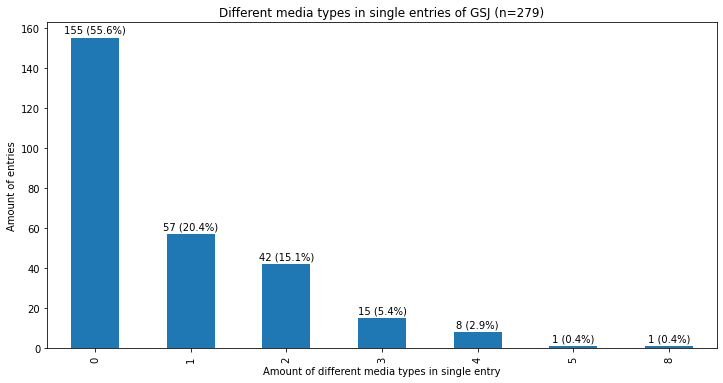

In [100]:

# PLOT BY COUNT 
sortedByMediaTypeCount=  eadf.sort_values(by=['media_types_count'])
# sortedByMediaTypeCount
mediaTypesCountValueCounts= sortedByMediaTypeCount['media_types_count'].value_counts(sort=False)
#plot
graph= mediaTypesCountValueCounts.plot(kind='bar', figsize= (12,6), 
                                       title= 'Different media types in single entries of GSJ (n='+ str(nEntries)+")",
                                       xlabel="Amount of different media types in single entry", ylabel='Amount of entries')

#annotate bars 
for p in graph.patches:
    value= p.get_height()
    perc= np.round((value/nEntries)*100., decimals=1)
    graph.annotate(str(value)+" ("+ str(perc)+"%)",
                   (p.get_x()+p.get_width()/2., p.get_height()),ha='center',
                   va='center',xytext=(0, 8),textcoords='offset points')

#save plot 
if savePlots==True: 
    filename='gsc_media_types.png'
    graph.get_figure().savefig(os.path.join(dataExportFolder,filename), 
                               bbox_inches = 'tight', dpi=300)
    print("Saved graph as: " + filename)

### 4.6 Exlude Zero media count & plot percentage distribution 

Entries with media:124
Saved graph as: gsc_media_types_perc.png


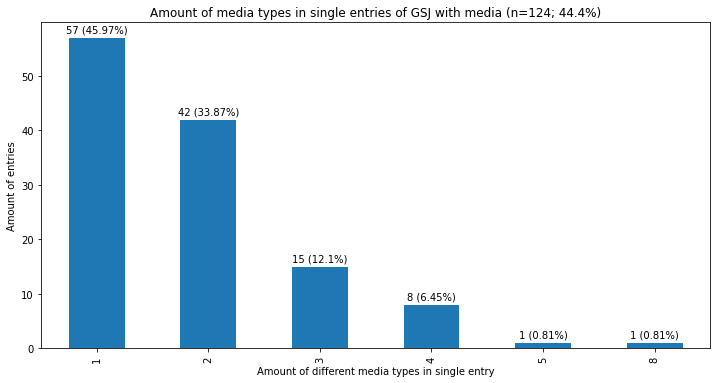

In [101]:
#drop entries with 0 MediaTypeCount 
mediaTypesVCount_excludingZero=mediaTypesCountValueCounts.drop(0)
# print(mediaTypesVCount_excludingZero)

nEntriesWithMedia= mediaTypesVCount_excludingZero.sum()
print("Entries with media:"+str(nEntriesWithMedia))
# get percentage over all entries 
ewm_perc=np.round(nEntriesWithMedia/nEntries*100., decimals=1)

gtitle='Amount of media types in single entries of GSJ with media (n='+ str(nEntriesWithMedia)+"; "+str(ewm_perc)+"%)"
                                    
graph=mediaTypesVCount_excludingZero.plot(kind='bar', figsize= (12,6), 
                                       title= gtitle,
                                          xlabel="Amount of different media types in single entry", 
                                        ylabel='Amount of entries')

#annotate bars with percentages 
for p in graph.patches:
    value= p.get_height()
    perc = np.round((value/nEntriesWithMedia)*100, decimals=2)
    graph.annotate(str(value)+" ("+str(perc)+"%)",
                   (p.get_x()+p.get_width()/2., p.get_height()),ha='center',
                   va='center',xytext=(0, 8),textcoords='offset points')
    
#save plot 
if savePlots==True: 
    filename='gsc_media_types_perc.png'
    graph.get_figure().savefig(os.path.join(dataExportFolder,filename), 
                               bbox_inches = 'tight', dpi=300)
    print("Saved graph as: " + filename)

### 4.7 Plot different media combinations 

Saved graph as: gsc_media_types_detailed.png


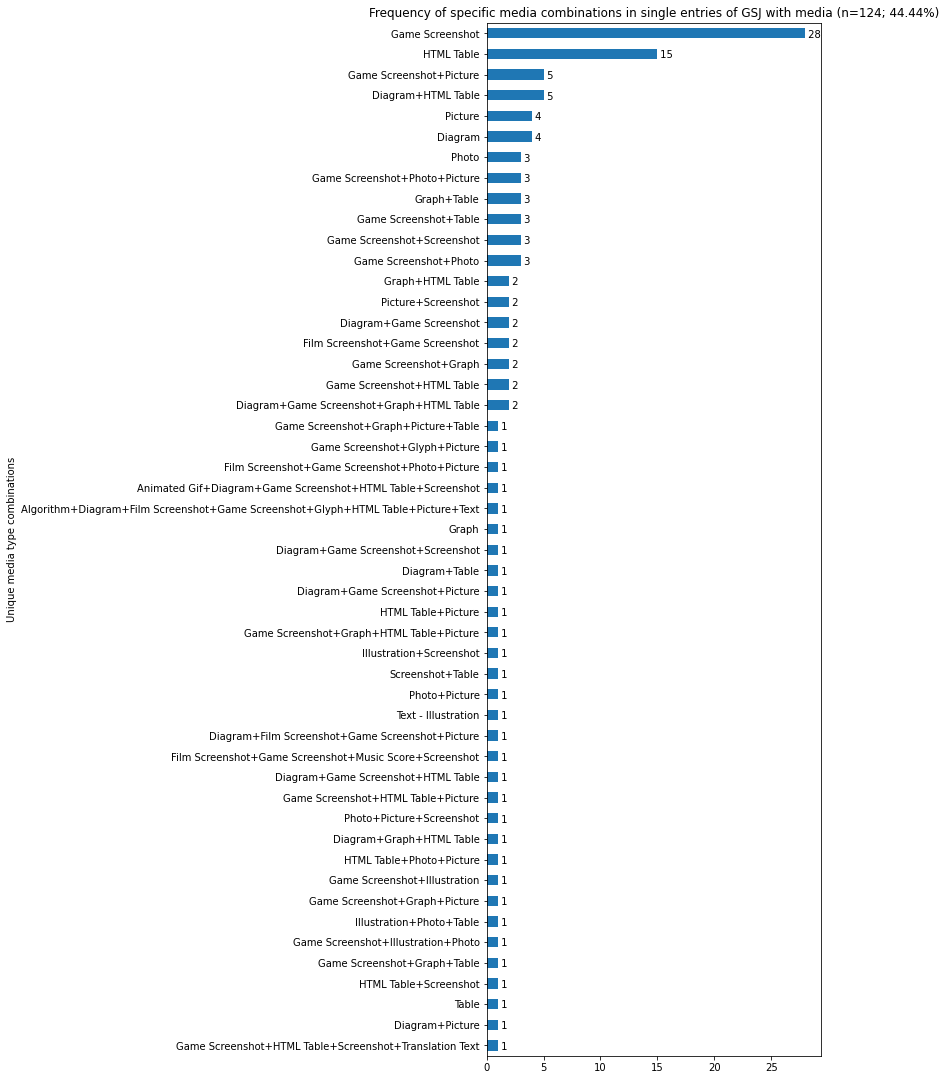

In [102]:
# sort and plot 
sortedByMediaTypes= eadf.sort_values(by=['media_types'])
# sortedByMediaTypes
mediaTypeValueCounts= sortedByMediaTypes['media_types'].value_counts(sort=True)

#exclude zero 
mediaTypeValueCounts_exZero=mediaTypeValueCounts[1::]


#get friendly labels 
friendlyLabels=[]
for keysets in mediaTypeValueCounts_exZero.keys(): 
    label=""
    for k in keysets: 
        if label=="": #for the first one 
            label=k
        else: 
            label+="+"+k #for any other prepend "+"
    friendlyLabels.append(label)     
    
#plot 
perc= np.round(nEntriesWithMedia/nEntries*100.0, decimals=2)
gtitle= 'Frequency of specific media combinations in single entries of GSJ with media (n='+ str(nEntriesWithMedia)+"; "+str(perc)+"%)"
graph=mediaTypeValueCounts_exZero.plot.barh( figsize= (6,19),
                                            title= gtitle,
                                            xlabel='Unique media type combinations', 
                                            ylabel='Amount of entries')

#set friendlier labels 
graph.set_yticklabels(friendlyLabels)

#sort descending 
graph.invert_yaxis()
#annotate graph 
for patch in graph.patches:
    graph.text(
        patch.get_width() + 0.0, 
        patch.get_y() + 0.3,
        " {:,}".format(patch.get_width()), 
        fontsize=10, va='center'
    )
    
#save plot 
if savePlots==True: 
    filename= 'gsc_media_types_detailed.png'
    graph.get_figure().savefig(os.path.join(dataExportFolder,filename), 
                               bbox_inches = 'tight', dpi=300)
    print("Saved graph as: " + filename)

### 4.8 Check presence of media types in different combinations 

Saved graph as: gsc_media_types_in_combinations.png


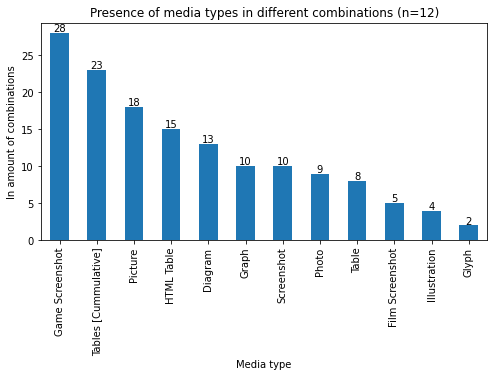

In [103]:
#get the frequency of media types in combinations 
mediaTypeInCombinations={}
combinations= mediaTypeValueCounts_exZero.keys()
# print(combinations)
for comb in combinations: 
    for combType in comb: 
        if combType in mediaTypeInCombinations: 
            mediaTypeInCombinations[combType]+=1
        else: 
            mediaTypeInCombinations[combType]=1
#             print (combType)

singleMedia=[]
for k in mediaTypeInCombinations: 
    if mediaTypeInCombinations[k]==1: 
        singleMedia.append(k)
        
#single media to exclude 
# print(singleMedia)
#remove single media 
for e in singleMedia: 
    del mediaTypeInCombinations[e]

mediaTypeInCombinations["Tables [Cummulative]"]= mediaTypeInCombinations["HTML Table"]+ mediaTypeInCombinations["Table"]

nMediaCombined= len(mediaTypeInCombinations)
#create dataframe
mediaCombination_df= pd.DataFrame({"mediaType" : mediaTypeInCombinations.keys(),
                                  "in_combinations":mediaTypeInCombinations.values()} )

#sort descending 
mcSorted=mediaCombination_df.sort_values(by=['in_combinations'], inplace=True, ascending=False)
#plot 
graph=mediaCombination_df.plot.bar(title="Presence of media types in different combinations (n="+str(nMediaCombined)+")",xlabel="Media type", ylabel="In amount of combinations",
                                  figsize= (8,4), 
                                  legend=False)#, xticks=mediaCombination_df['mediaType'] )
graph.set_xticklabels(mediaCombination_df.mediaType)


#annotate barts with percentages 
for p in graph.patches:
    value= p.get_height()
#     perc = np.round((value/nEntriesWithMedia)*100, decimals=2)
    graph.annotate(str(value),
                   (p.get_x()+p.get_width()/2., p.get_height()-.5),ha='center',
                   va='center',xytext=(0, 8),textcoords='offset points')


#save plot 
if savePlots==True: 
    filename= 'gsc_media_types_in_combinations.png'
    graph.get_figure().savefig(os.path.join(dataExportFolder,filename), 
                               bbox_inches = 'tight', dpi=300)
    print("Saved graph as: " + filename)

## Part 6: Scan entries for video links & plot graph
### 6.1 Scan all entries for hyperlinks

In [26]:
# kept separate from the primary scrape to avoid delays, and to keep things more agile and modular

allEntryLinks={} #dictionary to hold all href data per entry 

verbose= False

print("Scanning entries for Hyperlinks. Wait for confirmation message.. (~1min)")
#scanning could also check for linked files. 
#Besides enlarged images a known case is '.wav' files, submited and uploaded similarly as figures 
for index, row in edf.iterrows(): 

    #print every 20 
    if index>0 and index % 20==0: 
        print("processed "+ str(index)+" of "+ str(nEntries)) 
    url=row['url']
    
    #Get all Hrefs 
    links= getLinksInPage(url)
    #save to array 
    allEntryLinks[index]= links

print("Scan Finished ")

Scanning entries for Hyperlinks. Wait for confirmation message.. (~1min)
processed 20 of 279
processed 40 of 279
processed 60 of 279
processed 80 of 279
processed 100 of 279
processed 120 of 279
processed 140 of 279
processed 160 of 279
processed 180 of 279
processed 200 of 279
processed 220 of 279
processed 240 of 279
processed 260 of 279
Scan Finished 


### 6.2 Filter hyperlinks, scan for video links 
Filter for valid links. 
Scan for links that match Youtube or Vimeo, and plot graph with their frequencies

In [27]:
## FILTER Hyperlinks to get valid entries (as much as possible )

#video streaming sites 
videoStreamingSites= ['youtu.be', 'youtube.com','vimeo.com','dailymotion.com', 'twitch.tv'] #'archive.org'

#if a link starts with the following, skip 
ignoreLinks=['http://validator.w3.org',
             'http://www.gamestudies.org/about', 
             'http://gamestudies.org/about',
            'http://gamestudies.org/rss']

ignorePrecise=['http://gamestudies.org', 'http://www.gamestudies.org', '/about.html', '../about.html']

# validLinks={}
hrefs= [[] for _ in range(nEntries)] # list of hyperlinks
videoRefs=[0]*nEntries

brokenLinks=[]#list of broken links 

for entryIndexKey in allEntryLinks: 
    
    #loop through entry links 
    for link in allEntryLinks[entryIndexKey]: 
        
        
        #skip if url is None 
        if link is None :
            if verbose: 
                print("skip none ")
            continue
        
        #remove white spaces
        link= link.strip()
        
        if link=='/':
            if verbose: 
                print("Skip '/'")
            continue
        
        #skip emails 
        if link.startswith('mailto'): 
            if verbose: 
                print("skip email: "+ link)
            continue
        #skip if internal link to footnote/endnote
        if link.startswith('#'): 
            if verbose:
                print("Ignore #: "+ link)
            continue
        #prepend HTTP in links that dont have that 
        if link.startswith('www.'): 
            link="http://"+ link
        #skip ignore cases
        if any( link.startswith(ignoreLink) for ignoreLink in ignoreLinks ): 
            if verbose: 
                print("Ignore case in:"+ link)
            continue
        #ignore cases 
        if any (link == ignore for ignore in ignorePrecise): 
            if verbose: 
                print("ingore gs: "+ link)
            continue
        
        #filter internal game studies links
        
        #fix broken GS links / add http:// for game studies journal links without
        if link.startswith('gamestudies.org/'): 
            link= "http://www."+ link
            
          #this gets rid of a lot of remaining invalid links 
        if not is_valid(link): 
#             print("invalid link "+ str(link))
            brokenLinks.append(link)
            continue 
        
        if link.startswith('http://gamestudies.org') or link.startswith('http://www.gamestudies.org'):
            split = link.split('/')
            #skip GSJ about link
            if split[-1]=='about' or split[-2]=='about': 
                if verbose: 
                    print ("skip about: "+ link)
                continue
            #skip GSJ archive link
            if split[-1]=='archive' or split[-2]=='archive': 
                if verbose:
                    print ("skip archive: "+ link)
                continue
            #skip link to GSJ issue  
            if len(split)==4 or (len(split)==5 and split[4]==''): 
                if verbose: 
                    print("Skip issue number: "+ link)
                continue
            #skip internal footnotes/endnotes 
            if split[-1].startswith('#'): 
                if verbose: 
                    print("Skip internal #link: "+ link)
                continue
            #skip links to 'issue art' (two cases)
            if len(split)>3 and split[3]=='articleimages': 
                if verbose: 
                    print ("Skip issue art: "+ link)
                continue
            if len(split)>4 and split[4]=='issue-art': 
                if verbose: 
                    print ("Skip issue art: "+ link)
                continue 

        # if all checks passed then add to list 
        hrefs[entryIndexKey].append(link)
        

#print links 
print("Found: "+ str(len(hrefs))+" unique websites")
#print broken link count -- mostly (relative) internal links, links to images,
#and urls without www or http prefix 
print("Found "+ str(len(brokenLinks))+" broken hyperlinks (see \'brokenLinks\').")
# print broken links with line below 
# print(brokenLinks)
        
# problematic links (spaces inbetween the url, or connected with text, or characters missing)
# - 'Onlinehttp://blogs.suntimes.com/ebert/2010/07/okay_kids_play_on_my_lawn.html'
# - 'ttp://www.wowhead.com/npc=23616#'
# - 'http://www.gamasutra.com/ php-bin/news_index.php?story=19104'
# - 'http://www.washingtontimes.com/news/2005/jan/19/20050119- 120236-9054r/?page=all'

#loop through valid links and look for video streaming sites 
for i in range(0, len(hrefs)): 
    for link in hrefs[i]: 
        if any (site in link for site in videoStreamingSites): 
            if verbose: 
                print(str(i)+" : video "+ link)
            videoRefs[i]+=1
#     if videoRefs[i]>0: 
#         print(str(i)+" has "+ str(videoRefs[i])+" videolinks")

        #skip prefix except if 'blogs', 'blogspot', 'wordpress'

#Add column 'hrefs' to dataframe
edf['hrefs']=hrefs
edf['videoRefs']= videoRefs
nVideoRefs= edf['videoRefs'].sum()
print("Video references found: "+ str(nVideoRefs))
edf.head()

#print("TODO: ADD EXPORT FOR DF")

Found: 279 unique websites
Found 93 broken hyperlinks (see 'brokenLinks').
Video references found: 94


,title,url,imageUrls,imageCount,tableCount,issueId,year,issueNumber,media_types,media_types_count,hrefs,videoRefs
entryIndex,,,,,,,,,,,,
0,The Gaming Situation,http://www.gamestudies.org/0101/eskelinen/,"[eskelinen1.gif, eskelinen2.gif, eskelinen3.gi...",4,0,101,2001,1,[],0,[http://www.dichtung-digital.de/2001/05/29-Esk...,0
1,Is It Possible to Build Dramatically - Compel...,http://www.gamestudies.org/0101/bringsjord/,"[2_files/img3.gif, 3_files/img4.gif, 6_files/i...",27,1,101,2001,1,"[Diagram, Table, HTML Table]",3,[http://diac.it-c.dk/cgdt],0
2,The repeatedly lost art of - studying games,http://www.gamestudies.org/0101/juul-review/,[],0,0,101,2001,1,[],0,"[http://www.jesperjuul.dk/en, http://diac.it-c...",0
3,The Sims: Grandmothers are cooler than trolls,http://www.gamestudies.org/0101/frasca/,[],0,0,101,2001,1,[],0,"[http://www.babyz.net/, http://www.salon.com/t...",0
4,Beyond Myth and Metaphor*,http://www.gamestudies.org/0101/ryan/,[],0,0,101,2001,1,"[Algorithm, Diagram, Film Screenshot, Game Scr...",7,[http://diac.it-c.dk/cgdt],0


### 6.3 Plot Video link frequency in entries 

Video bearing entries:29
Video bearing entries percentage:10.39
Saved graph as: gsc_videolink_frequency.png


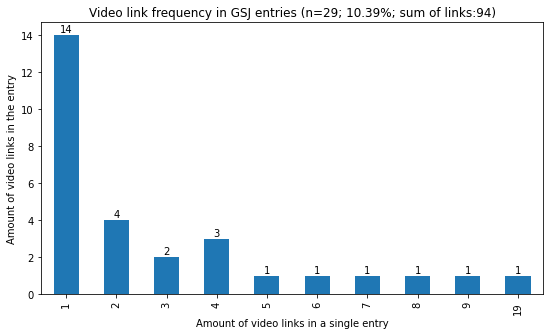

In [28]:
# Plot frequency of Video Links in Entries 
#sort, and count values
byVideoCount=edf.sort_values(by=['videoRefs'])
byVideoCountValueCounts= byVideoCount['videoRefs'].value_counts(sort=False)
#exclude zero values
byVideoCountValueCounts= byVideoCountValueCounts.drop(0)

# print(byVideoCountValueCounts)
nVideoBearingEntries= byVideoCountValueCounts.sum()
print("Video bearing entries:"+str(nVideoBearingEntries) )
videoBearningEntriesPerc= np.round(nVideoBearingEntries/nEntries*100., decimals=2)
print("Video bearing entries percentage:"+str(videoBearningEntriesPerc) )

#plot 
graph= byVideoCountValueCounts.plot(kind='bar', 
                                    title="Video link frequency in GSJ entries (n="+str(nVideoBearingEntries)+"; "+str(videoBearningEntriesPerc)+"%; sum of links:"+str(nVideoRefs)+")",
                 xlabel="Amount of video links in a single entry", 
                 ylabel="Amount of video links in the entry", 
                                    label='Number of entries', 
                                    figsize=(9,5))

#annotate bars with values 
for p in graph.patches:
    count= p.get_height()
    graph.annotate(count,
                   (p.get_x()+p.get_width()/2., p.get_height()),ha='center',
                   va='center',xytext=(0, 6),textcoords='offset points') 

#save plot 
if savePlots==True: 
    filename='gsc_videolink_frequency.png'
    graph.get_figure().savefig(os.path.join(dataExportFolder,filename), 
                               bbox_inches = 'tight', dpi=300)
    print("Saved graph as: " + filename)

### 6.4 Strip URLs to their root components and list most popular websites 

In [30]:
#remove http, https, www. and return root url 
def get_strippedUrl(url, keepPrefix=False): 
#     if url.startswith("file"): print("FILE:"+ url)
    
    #remove https
    skip= 'https://'
    if url.startswith(skip): 
        url= url[len(skip)::]
    #remove http
    skip= 'http://'
    if url.startswith(skip): 
        url= url[len(skip)::]
    #remove www.
    skip= 'www.'
    if url.startswith(skip): 
        url= url[len(skip)::]
    #split by '/'
    result= url.split('/')[0]
    #return first part 
    if keepPrefix==True: 
        return result 
    else: # or check for root url
        dotSplit= result.split('.')
        if len(dotSplit)>2  and len(dotSplit[-1])>2: #and not dotSplit[-2] in ['blogspot','wordpress']: 
            result=dotSplit[-2]+'.'+dotSplit[-1]
            #for the case of 2 digit urls, for example uk
            if dotSplit[-1]=='uk' and len(dotSplit)>=3: 
                result= dotSplit[-3]+'.'+result
        #return 
        return result
    


#dict of common links 
commonLinkInstances={}
commonLinkEntries={}
commonLinkCases={}

#create dictionaries 
for index, entry in edf.iterrows(): 
    for href in entry['hrefs']: 
#         if href=='http://%22' : print("!!!!!!!!!!!!!!!!!!!!!!!!!!  "+ entry['url'] )
        #strip url to its root 
        strippedUrl= get_strippedUrl(href, False)
#         print(strippedUrl+" "+ href)
        #merge youtube.com and youtu.be 
        if strippedUrl=='youtu.be': 
            strippedUrl='youtube.com'
        #merge doi with e.g. dx.doi.org
        if strippedUrl.endswith('doi.org'): 
            strippedUrl= 'doi.org'
        #all entries in 'journals.sfu.ca' are from the Loading journal 
        if strippedUrl=='journals.sfu.ca': 
            strippedUrl='[Loading Journal]'
        
        #if it exists add index / iterate 
        if strippedUrl in commonLinkInstances: 
            commonLinkInstances[strippedUrl]+=1 ##iterate counter
            commonLinkCases[strippedUrl].append(href)#add href url into cases 
            if  not index in commonLinkEntries[strippedUrl]: ## add entry index if not there
                commonLinkEntries[strippedUrl].append(index) 

        else: #otherwise create first entry 
            commonLinkEntries[strippedUrl]=[index] # start array
            commonLinkInstances[strippedUrl]=1 #set counter to one 
            commonLinkCases[strippedUrl]=[href]            


print ("Unique websites: "+ str(len(commonLinkCases)))

#print("TODO: ADD EXPORT FOR DF")


Unique websites: 872


### Plot common websites 

Saved graph as: gsc_popular_websites.png


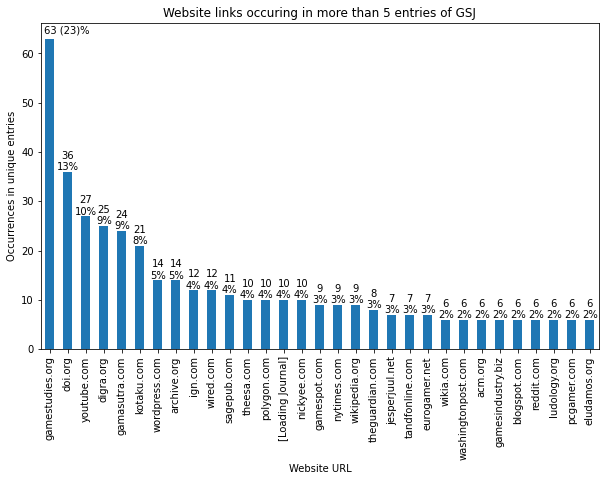

In [34]:
#filter data to get websites appearaing in more than X different entries 
websiteFrequencyToPlot=5

#assemble data - popular links, in 
hrefData={}
hrefsIgnored= {}
for k in commonLinkEntries: 
    # if a page is mentioned in more than X amount of in different entries 
    linkInXDifferentEntries= len(commonLinkEntries[k])
    #if larger than filter 
    if linkInXDifferentEntries>websiteFrequencyToPlot: 
        #print metrics 
#         print(k+ " is referened in " +str(len(commonLinkEntries[k]))+" different articles, "+str(commonLinkInstances[k])+ " times overall" )
        hrefData[k]=len(commonLinkEntries[k])
    else: 
        hrefsIgnored[k]= len(commonLinkEntries[k])

#print filtered cases 
# print(hrefData)
#print what is ignored from this filtering
# print(hrefsIgnored)
#check for 
# print(commonLinkCases['gamestudies.org'])

#make dataframe 
href_data= {"website": hrefData.keys(), 
                       "occurences": hrefData.values()}

#create dataframe
href_df= pd.DataFrame(href_data)

#for coloring / grouping 
# game studies ['gamestudies.org', 'digra.org', 'eludamos.org']
# general academic ['doi.org', 'tandfonline.com', 'acm.org', 'sagepub.com']
# news ['theguardian.com','wired.com', 'nytimes.com', 'washingtonpost.com']
# game culture ['gamasutra.com', 'kotaku.com', 'ign.com','polygon.com' ]

#sort
href_sorted= href_df.sort_values(by=['occurences'],ascending=False)

#plot
graph= href_sorted.plot(kind='bar', title='Website links occuring in more than '+str(websiteFrequencyToPlot) +" entries of GSJ", 
                        figsize= (10,6), 
                       xlabel="Website URL", ylabel="Occurrences in unique entries", 
                       legend=False)

# graph.color(barColors)
#set labels full 
graph.set_xticklabels(href_sorted.website)
# graph.legend=False


#annotate bars with percentages 
for i in range(0, len(graph.patches)): 
    p= graph.patches[i]
    value= p.get_height()
    perc = round((value/nEntries)*100) #round to integer
    if i==0: 
        graph.annotate( str(value)+ ' ('+str(perc)+")%",
                   (p.get_x()+p.get_width()/2. -.3, p.get_height()+0.0),ha='left',
                   va='center',xytext=(0, 8),textcoords='offset points')
    else: 
        graph.annotate( str(value)+ '\n'+str(perc)+"%",
                   (p.get_x()+p.get_width()/2., p.get_height()+0.5),ha='center',
                   va='center',xytext=(0, 8),textcoords='offset points')


#Snippet for checking precise website entries 
lookup= False 
var='tandfonline.com'#'journals.sfu.ca'#'nickyee.com'#'wordpress.com' #'gamestudies.org'
if lookup: 
    print(var+ " is referened in " +str(len(commonLinkEntries[var]))+" different articles, "+str(commonLinkInstances[var])+ " times overall" )
    #see cases :
    print (commonLinkCases[var])
    
#save plot 
if savePlots==True: 
    filename= 'gsc_popular_websites.png'
    graph.get_figure().savefig(os.path.join(dataExportFolder,filename), 
                               bbox_inches = 'tight', dpi=300)
    print("Saved graph as: " + filename)

## Annex: Download Images from Game Studies Journal Entries
The function below will download all images from Entries of the Game Studies Journal.  
Images are saved inside the subfolder of the `<imageExportFolder>` variable (declared above). The folder should already exist. 
The filename used to keep images sorted is: `<paperIndex>_<year>_<imageIndexInPaper>_<originalImageName>.<original-file-extension>`

In [ ]:
#DOWNLOAD ALL IMAGES 
import requests
from PIL import Image

# Function to Save Images -- also saves Animated GIFs 
# adapted from https://stackoverflow.com/questions/46230082/how-to-use-python-download-all-the-image-including-gif-file
def download_file(url, filename, verbose=False): 
    local_filename = url.split('/')[-1]
    if verbose: print("Downloading {} ---> {}".format(url, local_filename))
    # NOTE the stream=True parameter
    r = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
    return local_filename
    

#function to download images from a dataframe row 
def downloadEntryImages(index, row):
    imageUrls= row['imageUrls'] #get image urls
    if len(imageUrls)>0: # if there are pictures links 
        print("Accessing #"+ str(index)+" "+ row['url'])
        imgCounter=0
        for img in imageUrls:
#             print (img)
            imgCounter+=1
            imgPath=''
            #check if image url is local  
            if img.startswith('www') or img.startswith('http'): 
                imgPath=img
            else:  #if url is local then join with article url 
                imgPath= urljoin (row['url'],img)

            #prefix for filesaving [paperIndex]_[year]_[imageIndexInPaper]_[imageName+extension]
            exportPrefix=str(index)+"_"+str(row['year'])+"_"
            #get image name (after the last '/')
            name= img.split("/")[-1]
            #split name and file extension 
            nameParts= name.split(".")
            imgExtension= nameParts[-1] #get file extension 
            name= nameParts[-2] 
            #assemble filename 
            filename =os.path.join(imageExportFolder, exportPrefix+str(imgCounter)+"_"+name+ "."+imgExtension)

            #call function to save image
            #this version saves animated GIFs too
            download_file(imgPath, filename)
            
            #BELOW: Alternative/Older version which generated errors with an entry that had JPGs with apparent transparency
            #and did not save animated gifs
#             #request image file 
#             imgFile = Image.open(requests.get(imgPath, stream = True).raw)

#             # Special clause for the case of ../1803/articles/braidon_schaufert 
#             # which has JPG images in RGBA (that cannot be saved to JPG)
#             # converting to RGB to save with original file extension 
#             if imgExtension.lower() in ['jpg', 'jpeg'] and imgFile.mode in ["RGBA", "P"]:
#                 imgFile=imgFile.convert("RGB")
#                 print ("JPG in RGBA :"+ row['url']+" :: "+ name)

#             #eventually save image locally 
#             imgFile.save(filename)
       
        #printout 
        print(str(imgCounter)+" images saved from entry #"+ str(index)+" : " +row['url']  )

# loop through entries / rows in dataframe  
for index,row in edf.iterrows():
    #enclose this in an if statement, example 'if index<20: ' to download less, or specific ones (e.g. index ==5 or index in [1,5,25])
    downloadEntryImages(index,row)

print("Images saved!")

## Function to get Entry Authors [inconclusive; not used]
It's pretty much impossible to consistently get authors from Entries in the Game Studies Journal --see comments below. But not necessarily needed for this application. Partial solution below.

In [ ]:
#Function to get authors. 
#pretty much impossible. The following is mostly a hack, except from case 1 that is straight forward. 
#authors are listed under different HTML elements
# 1. at best in 'metainfo' as H4
# 2. in '.left' in strong (<strong>author</strong>)
# 3. as H6 in bold (<b>author</b>)
# at worse, authors are not in bold, and neither under the title (see /0102/mortensen/ and /0102/squire/)
# uncaught cases are listed as "JANE DOE"
# for problematic articles see: 
# problematicUrls= ['http://www.gamestudies.org/0102/newman/','http://www.gamestudies.org/0102/pearce/','http://www.gamestudies.org/0101/bringsjord/','http://www.gamestudies.org/0101/frasca/', 'http://www.gamestudies.org/0202/wright/', 'http://www.gamestudies.org/0101/eskelinen/']

def getAuthors(url, verbose=False):
    html = urlopen(url)
    bs = BeautifulSoup(html, 'html.parser', from_encoding="UTF-8") ## need to force UTF 8 encoding, else it gets it wrong
    #most entries have metainfo, in which author names are listed under H4 
    # but then again, many entries don't have metainfo, in which case get the .left element, and then the <strong> elements
    # these are also the entries that Zotero cannot scrape as articles 
    metainfo= bs.find('div', id="metainfo")
    authors=[]
    if not metainfo is None: # easy case
        authors= metainfo.find_all('h4')
        authors= [author.string for author in authors]
        return authors
    
    #when there is no metainfo 
    if (verbose): print('no metainfo') 
    
    #try to get .left which should be only one 
    corner = bs.select('.left') # get 'left component', which should be only one
    if len(corner)!=0:
        if verbose: print ("try .left")
        for element in corner: 
            auths=element.find_all("strong")
            authors= [auth.text for auth in auths]
        #+ str(authors))#+" in "+ url )
        if authors!=[]: return authors 
    
    #H6
    if verbose: print("checking for H6")
    corner= bs.select('h6')
    if len(corner)!=0: 
        for element in corner: 
            bold= element.find_all('b')
            for i in bold: 
                if len(i)>0: 
                    authors.append(i.text)
        # hack for cases that bibliography is in the same container 
        if len(authors)>3: 
            return [authors[0]]
        elif len(authors)>0: 
            return authors
    #p.left 
    if verbose: print("PLEFT") 
    corner= bs.select('p.left')
    if len(corner)!=0: 
        for element in corner: 
            bold= element.find_all('strong')
            for b in bold: 
                if len(b)>0:
                    authors.append(b.text)
        if len(authors)>0: 
            return authors
        
    if (verbose): print("UNCAUGHT: Jane Doe")     
    return ['JANE DOE']


# Use commented-out code below (after generating edf dataframe) to scan for authors 
# for index, row in edf.iterrows(): 
#     url= row['url']
#     authors= getAuthors(url, False)
#     print(authors +" of " url)

## Older Tests
Below are test snippets and older tryouts

In [ ]:
#scan each paper url for images 
#save image links and image count per entry 
print("Scanning for image links. Wait for confirmation message... (~1min)")
images=[]
imageCount=[]
for url in urls: 
    urlImages=getImages(url)
    imageCount.append (len(urlImages))
    images.append(urlImages)
    
print("Finished image scan. Images Found: "+ str(sum(imageCount)))

#analyze image types // might be useful  
imageTypeDict={}
for paperImages in images: 
    if len(paperImages)>0: 
        for image in paperImages: 
            extension = (image.split("."))[-1].lower() #find part after period (file extension) and make lowercase
            if len(extension)>4: 
                print ("Ignoring image: "+ image)
                continue # only one occurence of -> http://www.w3.org/Icons/valid-html401
            if not extension in imageTypeDict.keys(): 
                imageTypeDict[extension]=0
            imageTypeDict[extension]+=1
        
print("image types")
#consolidate JPG and JPEG to one 
imageTypeDict['jpg']+= imageTypeDict['jpeg'] 
del imageTypeDict['jpeg']
print(imageTypeDict)


In [ ]:
#get HTML  tables 
print("Scanning for HTML Tables. Wait for confirmation message... (~1min)")
paperTables=[]
for url in urls: 
    t=getTables(url)
    paperTables.append(t)
#     if t>0: 
#         print(str(t) +" tables in: "+ url)

tableSum= sum(paperTables)
print("Finished HTML Table Scan. Found : "+ str(tableSum)+ " tables")

# tested to yield correct num of tables in 
# begy_consalvo (3) bringsjord, zagal_bruckman (2), allowaycarpenter (1), chapman ,blankscole ,
#dalisay_kushin_kim_forbes_david_somera, fromme, gardagrabarczyk, griebel 

In [ ]:
#get entry titles 

print("Scanning for Entry Titles. Wait for confirmation message...")
entryTitles=[]
for url in urls: 
    title=getTitle(url)
    title= title.replace("   ", "") #some entries have multiple spaces, this kills some of them
    title=title.replace("\n", "-") #removes new lines 
    entryTitles.append(title)
    
print("Finished Entry Title Scan.")
# print (entryTitles)

In [ ]:
# get per issue data 
entriesPerIssue= [0]*nIssues
imageCountPerIssue=[0]*nIssues
imagesPerIssue=[0]*nIssues
imagesPerIssueMax=[0]*nIssues

overalMaxImageCount=0

for i in range(0, len(urls)): 
    issueIndex= dictionaryOfIssues[issueIds[i]]
    entriesPerIssue[issueIndex-1]+=1
    imageCountPerIssue[issueIndex-1]+= imageCount[i]
    if imagesPerIssue[issueIndex-1]==0: 
        imagesPerIssue[issueIndex-1]=[]
    imagesPerIssue[issueIndex-1].append(imageCount[i])
    imagesPerIssueMax[issueIndex-1]=max(imagesPerIssueMax[issueIndex-1], imageCount[i])
    overalMaxImageCount= max (overalMaxImageCount, imageCount[i])

# image count, excluding top contributing paper 
imageCount_excludTopContrib=[0]*nIssues
for i in range(0, nIssues): 
    imageCount_excludTopContrib[i] = imageCountPerIssue[i]- imagesPerIssueMax[i]

# print(imageCountPerIssue)
# print(imagesPerIssue)
# print (imagesPerIssueMax)


print("Max images in single entry : "+ str(overalMaxImageCount))

# Print list of Issues with number of entries and cumulative sum of images 
for i in range(0,nIssues):
    print("Issue:"+ str(i+1)+" Entries:"+ str(entriesPerIssue[i])+ " Img Sum:"+ str(imageCountPerIssue[i]))
    print("MostImgsInSingleEntry:"+ str(imagesPerIssueMax[i])+ "; Total excl. top contrib.: "+ str(imageCount_excludTopContrib[i]))
    

In [ ]:
#PLOTS 
plt.figure(figsize=(8,4))#, dpi=300)
#image count sum 
plt.plot(idf['issueNumber'],idf['imageCountPerIssue'],
         'b.-' , label="Issue Image Sum")
#single top contributor 
plt.plot(issueNumber, imagesPerIssueMax,
         'g:', label="Single entry with most imgs")
#without top contributor 
plt.plot(issueNumber,imageCount_excludTopContrib,
         '--', label="Excluding top contrib.")
#issue mean 
plt.plot(issueNumber,meanImgCount_perIssue,
         '-', label="Mean")

#plot options 
plt.legend()# show legend
plt.title("Images per Journal Issue")
plt.xticks(issueNumber[::5])
plt.xlabel("Issue Index")
plt.ylabel("Image Count")
plt.xlim(xmin=0)

plt.show()

#save graph 
#plt.savefig('mygraph.png', dpi=300)

In [ ]:
# box chart 
imagesPerIssue
plt.style.use('default')
plt.figure(figsize=(5,8))
boxes= plt.boxplot(imagesPerIssue,  vert=False)
#labels= issueNumber,
# for box in boxes['boxes']: 
#     box.set(facecolor='white')
# plt.xticks(issueNumber[::5])
# plt.xticks(range(1,nIssues+1))
plt.xticks(range(0,30)[::5])
# plt.yticks(issueNumber[::3].tolist())
plt.title("Images per paper per issue")
plt.xlabel("Entry Image Number")
plt.ylabel("Issue Number")
plt.show()
# plt.legend()

In [ ]:
import pandas as pd
import matplotlib.ticker as mtick

#create data frame with all data
data={
    'url': urls, 
    'issue_id':issueIds, 
    'year': issueYears, 
    'issue_index': ascendingPublicationIndexes,
    'image_count': imageCount
#     'issue_number':issueNumbers
}
df= pd.DataFrame(data)

df.sort_values(by=['image_count'], inplace=True)
df.insert(0, 'paper_id', range(1, len(df)+1))
# df.reset_index(inplace=True, drop=True)

plot=df.plot(x="paper_id", y="image_count", 
             xlabel='image index', 
             ylabel='Image Count', 
             title='Image Frequency',
             legend='image count')

# plot.xaxis.set_major_formatter(mtick.PercentFormatter())

# boxplot= 
# df['image_count'] #.value_counts()

fig, ax=plt.subplots()
df['image_count'].value_counts().plot(ax=ax, kind='bar')

# bp= df.plot.bar(x= range(0, 27), y=df['image_count'].value_counts())